# Face Verification

* Face Authentication (also called verification) involves a one to one check that compares an input image (also called a query image, probe image or simply probe) with only the image (or class) that the user claims to be. In simple words, if you stand in front of a face authentication system and claim to be a certain user, the system will ONLY check if you are that user or not.


<img src="images/face_authentication.jpg" style="width:280px;height:100px;">


# Face Recognition

* Face Recognition (or Identification) is another thing, though ofcourse related. It involves a one to many comparison of the input image (or probe or query image) with a template library. In simple words, in a face recognition system the input image will be compared with ALL the classes and then a decision will be made so as to identify to WHO the the input image belongs to. Or if it does not belong to the database at all.

<img src="images/face_recognition2.jpg" style="width:280px;height:150px;">


Like I just said before, though both Authentication and Recognition are related there are some differences in the method involved, which are obvious due to the different nature of both.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

C:\Users\RAVI GUPTA\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.models import load_model
#--Importing keras model and necessary classes
from keras.models import Model
from keras.models import Sequential
from keras.layers import Activation,Conv2D,Dense,MaxPool2D,Input,Flatten,BatchNormalization,Dropout
from keras.models import model_from_yaml



Using TensorFlow backend.


# Loading Data

In [3]:
akshar_image_folders = os.listdir("train")

In [4]:
list_of_images = []

list_of_labels = []

label_index = 0

for akshar_folder in akshar_image_folders:
    
    each_folder_path = os.path.join("train",
                                   akshar_folder)
    
    images = os.listdir(each_folder_path)
    
    img_shape = plt.imread(os.path.join(each_folder_path,images[0])).shape
    
    blank_array = np.zeros((len(images),(img_shape[0]*img_shape[1]))) 
    
    blank_label_array = label_index*(np.ones((len(images),1)))
    
    index = 0
    
    for image in images:
        
        img_in_array = plt.imread(os.path.join(each_folder_path,image))
        
        blank_array[index] = img_in_array.reshape(1,(img_in_array.shape[0]*img_in_array.shape[1]))
        
        index += 1
        
    list_of_images.append(blank_array)
    
    list_of_labels.append(blank_label_array)
    
    label_index += 1

In [5]:
tuple_of_label_arrays = tuple(list_of_labels)

tuple_of_arrays = tuple(list_of_images)

stacked_up_images = np.concatenate(tuple_of_arrays)

print(stacked_up_images.shape)

stacked_up_labels = np.concatenate(tuple_of_label_arrays)

print(stacked_up_labels.shape)

stacked_up_labels = np.int32(stacked_up_labels)

rawdata = pd.DataFrame(stacked_up_images)

(78200, 1024)
(78200, 1)


#  Loading Pre Trained Model

In [15]:
with open('trained_model.yaml','r') as yaml_file:
    trained_model_yaml = yaml_file.read()
  
  
pre_trained_model = model_from_yaml(trained_model_yaml)
  
pre_trained_model.load_weights('CNN_Devanagari_model.h5')

In [16]:
# pre_trained_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

pre_trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        260       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 10)        40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 10)        2510      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 10)        40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2560)              3688960   
__________

# Adding 128 Dimensional Vector Layer

In [18]:
pre_trained_model.add(Dense(units=128,activation=tf.nn.relu,kernel_initializer='he_normal'))

# pre_trained_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [19]:
pre_trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 10)        260       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 10)        40        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 10)        2510      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 10)        40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2560)              3688960   
__________

C:\Users\RAVI GUPTA\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




### 1.2 - The Triplet Loss

For an image $x$, we denote its encoding $f(x)$, where $f$ is the function computed by the neural network.

<img src="images/f_x.png" style="width:380px;height:150px;">

<!--
We will also add a normalization step at the end of our model so that $\mid \mid f(x) \mid \mid_2 = 1$ (means the vector of encoding should be of norm 1).
!-->

Training will use triplets of images $(A, P, N)$:  

- A is an "Anchor" image--a picture of a person. 
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example. 

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$$

You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{N}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

Here, we are using the notation "$[z]_+$" to denote $max(z,0)$.  

Notes:
- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small. 
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large, so it thus makes sense to have a minus sign preceding it. 
- $\alpha$ is called the margin. It is a hyperparameter that you should pick manually. We will use $\alpha = 0.2$. 

Most implementations also normalize the encoding vectors  to have norm equal one (i.e., $\mid \mid f(img)\mid \mid_2$=1); you won't have to worry about that here.

**Exercise**: Implement the triplet loss as defined by formula (3). Here are the 4 steps:
1. Compute the distance between the encodings of "anchor" and "positive": $\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$
2. Compute the distance between the encodings of "anchor" and "negative": $\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$
3. Compute the formula per training example: $ \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2 + \alpha$
3. Compute the full formula by taking the max with zero and summing over the training examples:
$$\mathcal{J} = \sum^{N}_{i=1} \large[ \small \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2+ \alpha \large ] \small_+ \tag{3}$$

Useful functions: `tf.reduce_sum()`, `tf.square()`, `tf.subtract()`, `tf.add()`, `tf.reduce_mean`, `tf.maximum()`.

# Extracting Anchor , Positive  and  Negative Set of Images
## Encoding face images into a 128-dimensional vector
* #--collecting the class_1 images as a Anchor and Positive images for Face Verification
* #--collecting the class_2 images as a Negative images  for Face Verification

In [20]:
reshaped_data = np.reshape(stacked_up_images,(-1,32,32,1)) 

#--collecting the class_1 images as a Anchor and Positive images for Face Verification
class_1_index = np.where(stacked_up_labels==1)[0]
class_1_images = reshaped_data[class_1_index,:,:]

print(class_1_images.shape)

mid = int(class_1_images.shape[0]/2)

Anchor =  pre_trained_model.predict(class_1_images[:mid,:,:])
Positive = pre_trained_model.predict(class_1_images[mid:,:,:])

print(Anchor.shape,Positive.shape)

#--collecting the class_2 images as a Negative images  for Face Verification 
class_2_index = np.where(stacked_up_labels==2)[0]
class_2_images = reshaped_data[class_2_index,:,:]

print(class_2_images.shape)

Negative = pre_trained_model.predict(class_2_images[:850,:,:])

print(Negative.shape)


y_true = [None,None,None]
y_pred = [Anchor,Positive,Negative]



(1700, 32, 32, 1)
(850, 128) (850, 128)
(1700, 32, 32, 1)
(850, 128)


In [21]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    anchor,positive,negative = y_pred[0],y_pred[1],y_pred[2]


    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)))
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)))
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.maximum(tf.reduce_mean(basic_loss), 0.0)
    ### END CODE HERE ###

    return loss
  
  


In [22]:
with tf.Session() as test:
    tf.set_random_seed(1)
    
    loss = triplet_loss(y_true, y_pred)

    print("loss = " + str(loss.eval()))

loss = 0.0


In [23]:
pre_trained_model.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

# Face(Image) Verification Function

In this function we are taking two different image array.Compare the L2 distance(to the threshold 0.7)

In [24]:
def verify(predicted_image,actual_image,pre_trained_model):
    
    predicted_image_embedding = pre_trained_model.predict(predicted_image)
  
    actual_image_embedding = pre_trained_model.predict(actual_image)
  
    dist = np.linalg.norm(predicted_image_embedding - actual_image_embedding)
  
    if dist<0.7:
        print('distance:',dist)
        print('image matched')
    else:
        print('distance:',dist)
        print('image not matched')
    

In [25]:
#--testing values
x1 = class_1_images[:1,:,:]  #--Anchor Image
x2 = class_1_images[100:101,:,:]  #---Positive Image
x3 = class_2_images[10:11,:,:]   #---Negative Image

# Verification

<img src="images/distance_kiank.png" style="width:480px;height:250px;">

In [26]:
#--Taking two different images
verify(x1,x3,pre_trained_model)

distance: 2.0079985
image not matched


In [27]:
#--Taking two Same images
verify(x1,x2,pre_trained_model)

distance: 0.0029724487
image matched


# Image Augmentation

* making testing set of images

Here we use the concept of Image Augmentation Techinque for making unique test values for testing our model.  

In [30]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True, vertical_flip=True,rotation_range=45,width_shift_range=0.2, height_shift_range = 0.2)

In [31]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             horizontal_flip=True, vertical_flip=True,rotation_range=45,width_shift_range=0.2, 
                             height_shift_range = 0.2)

datagen.fit(class_1_images)

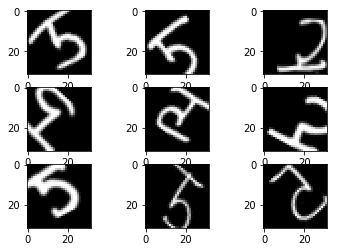

In [33]:
X_train = class_1_images
# Y_train = stacked_up_labels[class_1_index]

for X_batch in datagen.flow(X_train,batch_size=9,save_to_dir='testing_images',save_prefix='new'):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(32, 32), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

# Face(Image) Recognition

In [ ]:
database = pre_trained_model.predict(reshaped_data)
print(database.shape)

In [45]:
import os
akshar_image_folders = os.listdir(path='train')
print(akshar_image_folders)

['character_10_yna', 'character_11_taamatar', 'character_12_thaa', 'character_13_daa', 'character_14_dhaa', 'character_15_adna', 'character_16_tabala', 'character_17_tha', 'character_18_da', 'character_19_dha', 'character_1_ka', 'character_20_na', 'character_21_pa', 'character_22_pha', 'character_23_ba', 'character_24_bha', 'character_25_ma', 'character_26_yaw', 'character_27_ra', 'character_28_la', 'character_29_waw', 'character_2_kha', 'character_30_motosaw', 'character_31_petchiryakha', 'character_32_patalosaw', 'character_33_ha', 'character_34_chhya', 'character_35_tra', 'character_36_gya', 'character_3_ga', 'character_4_gha', 'character_5_kna', 'character_6_cha', 'character_7_chha', 'character_8_ja', 'character_9_jha', 'digit_0', 'digit_1', 'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7', 'digit_8', 'digit_9']


In [172]:
def recognize(image,database,pre_trained_model):
    embeded_image = pre_trained_model.predict(image)  #--shape:-(1, 128)
    
    dist_arr = np.sqrt(np.sum(np.square(np.subtract(embeded_image,database)),axis=1))  #--shape:-(78199, 128)
  
    min_dist_index = np.argmin(dist_arr)  #--give the index where minimum value is present
    
#     print(dist_arr[min_dist_index])
    
    if dist_arr[min_dist_index]<0.3:  #__checking it is below threshold value or not
  
        print("Index No of Image in Database from which it is nearest is:",min_dist_index)

        label = int(stacked_up_labels[min_dist_index,0])

        print('Belong from Class:',label)

        char_name = akshar_image_folders[label]

        print('Name of the character is:-',char_name)

        return(stacked_up_images[min_dist_index,:])
    
    else:
        return([])
  

# Actual Image

image_shape:- (32, 32)


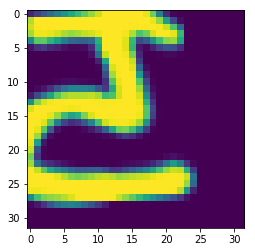

reshaped image shape:- (1, 32, 32, 1)


In [169]:
img = plt.imread('testing_images/new_814_6252.png')
print('image_shape:-',img.shape)

plt.imshow(img)
plt.show()

img = img.reshape((1,32,32,1))
print("reshaped image shape:-",img.shape)

# Predicted Image

Index No of Database from which it is nearest is: 2978
Belong from Class: 1
Name of the character is:- character_11_taamatar


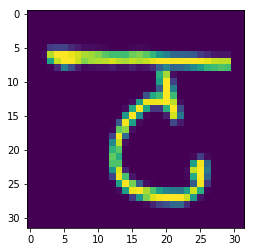

In [171]:
pred_img = recognize(img,database,pre_trained_model)   #--calling recognize function 

if (list(pred_img)):
    pred_img = pred_img.reshape((32,32))
    plt.imshow(pred_img)
    plt.show()
    
else:
    print('No Such Image Is In Database')
    
